# Open Ocean
# Open Earth Fundation

## Sampling Methodology: MPAs Refe

From the [IUCN Global Ecosystem Typology 2.0](https://portals.iucn.org/library/sites/library/files/documents/2020-037-En.pdf) it has that the marine global realms have 3 biomes (components of a core or transitional realm united by one or a few common major ecological drivers that regulate major ecological functions):
- M1: Marine shelf biome
- M2: Pelagic ocean waters biome
- M3: Deep sea floors biome

The purpose of this notebook is count the number of Ecosystem Functional Groups (EFG) in several MPAs around the world, making grids, to calculate the maximum statistical number of EFG possible in a grid.

### Data sources
The data needed for this project is available in the Ocean Program S3 Bucket in the following directions:

This folder contains the layers needed to calculate the number of ecosystems in a grid:
- IUCN Marine Ecosystem Typology: https://ocean-program.s3.amazonaws.com/data/raw/Ecosystems/

This folder contains a folder per MPA:
- MPAs: https://ocean-program.s3.amazonaws.com/data/raw/MPAs/

**In point 2 you can find a way to access this data**

### 1. Importing packages and libraries

In [1]:
# load basic libraries
import os
import glob
import math
import numpy as np
import pandas as pd

# to plot
import matplotlib.pyplot as plt

# to manage shapefiles
import shapely
import geopandas as gpd
from shapely.geometry import Polygon, Point, box

In [2]:
import fiona; #help(fiona.open)

In [3]:
%load_ext autoreload

In [4]:
#Run this to reload the python file
%autoreload 2
from marinebiodiversity_utils import *

### 2. Accessing the data

In [5]:
#To know the paths and names of the Ecosystem Functional Groups (EFG) files from AWS S3 bucket:

import boto3

s3 = boto3.resource('s3')
bucket = s3.Bucket('ocean-program')

eco_names = []

for obj in bucket.objects.filter(Prefix='data/raw/Ecosystems/'):
    name = obj.key[:]
    eco_names.append(f'https://ocean-program.s3.amazonaws.com/{name}')

This list of paths will be used as input to the clip_EFG function later

In [47]:
eco_names[0:4]

['https://ocean-program.s3.amazonaws.com/data/raw/Ecosystems/FM1_1_Deepwater_coastal_inlets.json',
 'https://ocean-program.s3.amazonaws.com/data/raw/Ecosystems/FM1_2_Riverine_estuaries_and_bays.json',
 'https://ocean-program.s3.amazonaws.com/data/raw/Ecosystems/FM1_3_Closed_open_inlets.json',
 'https://ocean-program.s3.amazonaws.com/data/raw/Ecosystems/M1_1_Seagrass_meadows.json']

In [45]:
#To know the paths and names of the MPAs files available in AWS S3 bucket:

s3 = boto3.resource('s3')
bucket = s3.Bucket('ocean-program')

List = [obj.key for obj in bucket.objects.filter(Prefix='data/raw/MPAs/')]

str_match = [s for s in List if 'geojson' in str(s)]
print(str_match)   

['data/raw/MPAs/ACMC.geojson', 'data/raw/MPAs/Ascension_Island.geojson', 'data/raw/MPAs/Galapagos.geojson', 'data/raw/MPAs/NorthAtlanticCurrent_Evlanov_Basin.geojson', 'data/raw/MPAs/PNMB.geojson', 'data/raw/MPAs/Papahanaumokuakea.geojson', 'data/raw/MPAs/Pitcairn_Islands.geojson', 'data/raw/MPAs/Rapa_Nui.geojson', 'data/raw/MPAs/Sinub_Island_Marine.geojson', 'data/raw/MPAs/South_Georgia_South_Sandwich_Islands.geojson']


In [46]:
#Let's to read one of the MPA file

MPA = gpd.read_file('https://ocean-program.s3.amazonaws.com/data/raw/MPAs/Ascension_Island.geojson')
MPA = MPA.set_crs(epsg=4326, allow_override=True)

### 3. Data analysis

1. Making a geoDataFrame with all geometries within the chosen MPA

In [48]:
%%time
joined = Clip_EFG(eco_names, MPA, 4326)

CPU times: user 3min 55s, sys: 11.3 s, total: 4min 7s
Wall time: 12min 33s


**Plot of the geometries in the MPA**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


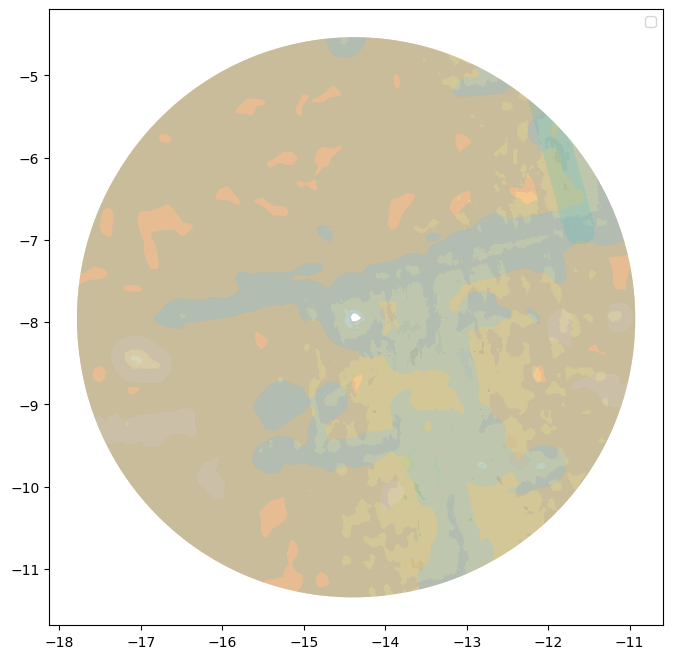

In [49]:
fig, ax = plt.subplots(figsize = (8,8))

ax.set_aspect('equal')

joined.plot(ax=ax, alpha = 0.15, cmap = 'tab20', edgecolor = 'grey', linewidth = 0.01)

plt.legend()
plt.show();

Counting the overlapping geometries

In [50]:
overlap_geo = count_overlapping_geometries(joined)

/Users/maureenfonseca/Desktop/Oceans/oceanprogram/Experimental_Work/marinebiodiversity_utils.py:196: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if this_row_boundary.type[:len('multi')].lower() == 'multi':
/Users/maureenfonseca/Desktop/Oceans/oceanprogram/Experimental_Work/marinebiodiversity_utils.py:217: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  new_gdf['geom_centroid'] = new_gdf.centroid


Making grids

In [51]:
hexagon = create_grid(MPA, "hexagon", 0.5, 4326)

Notice that there are two sources of error above:

    1.The longitudes span the globe - which explains why the hexagon frame is so massive
    2.Both lat and lon are bloated by an extra 20 degrees! This is due to the buffer function used in the create_grid function
    
### Solutions
1. Remove the buffer function
2. Split geometry along the antimeridian -> +-180 degrees lon

Obtaining the maximum number of habitats in a grid

In [52]:
#This is to count how many ecosystems are in each grid 
merged2 = gpd.sjoin(overlap_geo, hexagon, how='left')

merged2['n_habitats']= overlap_geo['count_intersections']

# Compute stats per grid cell
dissolve = merged2.dissolve(by="index_right")#, aggfunc="count")

# put this into cell
hexagon.loc[dissolve.index, 'n_habitats'] = dissolve.n_habitats.values

### 4. Plot each grid color-coded to the number of habitats contained within it

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


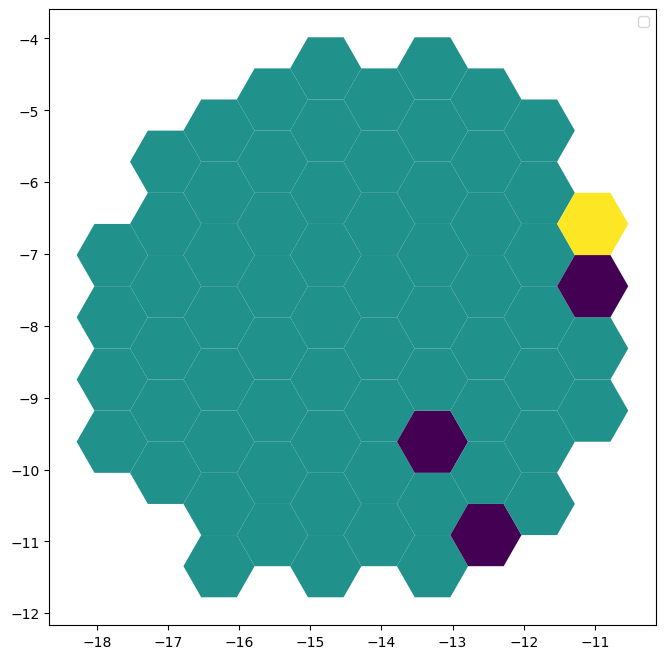

In [53]:
fig, ax = plt.subplots(figsize = (8,8))

ax.set_aspect('equal')
hexagon.plot(ax = ax, column = 'n_habitats', cmap = 'viridis', edgecolor = 'grey', linewidth = 0.01)

plt.legend()
plt.show()

### 5. What is the maximum value?

In [54]:
# known the max # of habitats in a grid
max_value = hexagon['n_habitats'].max()

print(max_value)

7.0


### Takeaway

The purpose of this code is to calculate the number of EFG per grid in different MPAs around the world to obtain an approximate maximum value to use in a global normalization factor.

The maximum value per MPA depends on:
- The size of the grid
- The location of the MPA

To do:
- Define the size of the grid that you want to use
- Define how many MPAs are enough to have an approximate maximum acceptable value